# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [01:23<00:00, 717File/s]   


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

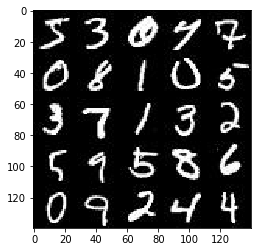

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

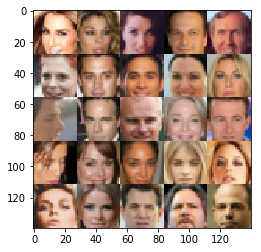

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/by-macbookpro/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 14x14x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 7x7x256
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.nn.dropout(x4, 0.8)
        # 7x7x512
        
        # Flatten
        flat = tf.reshape(x4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 7x7x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, 0.8)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    samples = []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
                    gen_sample = sess.run(
                        generator(input_z, data_shape[3], False),
                        feed_dict={input_z: batch_z})
                    samples.append(gen_sample)
        print("Done");
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 8.1578... Generator Loss: 0.0004


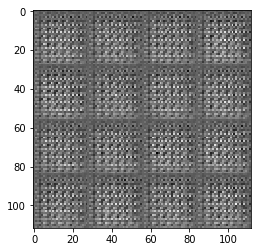

Epoch 1/2... Discriminator Loss: 1.8989... Generator Loss: 0.2398
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.4784
Epoch 1/2... Discriminator Loss: 1.7249... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 0.8958... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 0.7848... Generator Loss: 1.6272
Epoch 1/2... Discriminator Loss: 1.8506... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.8273


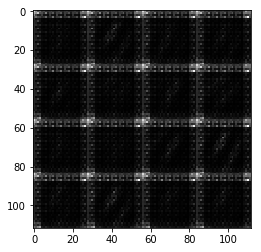

Epoch 1/2... Discriminator Loss: 0.9066... Generator Loss: 1.1274
Epoch 1/2... Discriminator Loss: 1.7917... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 0.5098
Epoch 1/2... Discriminator Loss: 1.7275... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 2.4220... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.1517... Generator Loss: 1.6422
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.7217


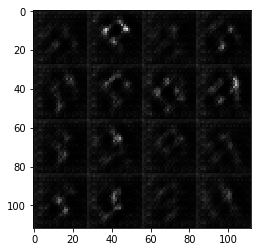

Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 1.7161... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 1.5404... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.7219... Generator Loss: 0.9235


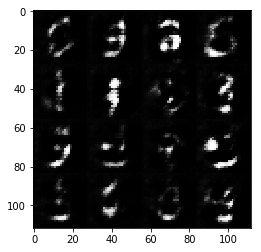

Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.7217... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.6301... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 1.5290... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.6983
Epoch 1/2... Discriminator Loss: 1.5970... Generator Loss: 0.3554


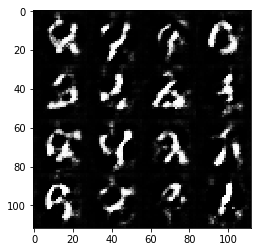

Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 1.0694
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 1.2931... Generator Loss: 0.6555
Epoch 1/2... Discriminator Loss: 1.5710... Generator Loss: 0.4529
Epoch 1/2... Discriminator Loss: 1.4648... Generator Loss: 0.6292
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.8252
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 1.1771


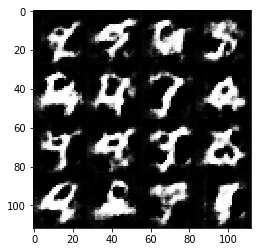

Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 1.0107
Epoch 2/2... Discriminator Loss: 1.4983... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 1.3392
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.6279
Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 1.3383... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.4546... Generator Loss: 0.5915


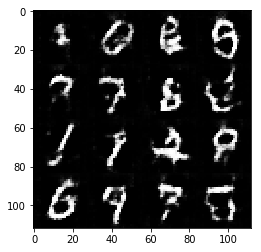

Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 0.6338
Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 1.1837
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 1.0832
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 1.1583
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 0.5631
Epoch 2/2... Discriminator Loss: 1.4994... Generator Loss: 1.1081


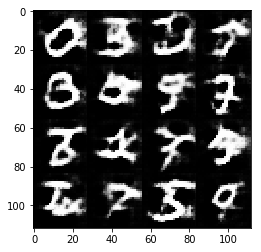

Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.5737
Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.8245
Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 1.5237... Generator Loss: 0.4223
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 1.0347
Epoch 2/2... Discriminator Loss: 1.4848... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.6595
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.7792


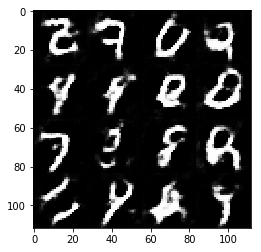

Epoch 2/2... Discriminator Loss: 1.5067... Generator Loss: 1.2330
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 1.2986
Epoch 2/2... Discriminator Loss: 1.3453... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 0.8043
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.8388
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.5993
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.9069


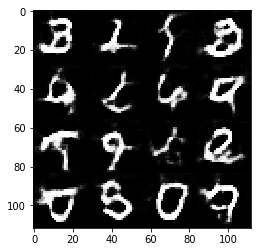

Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.7431
Done


In [63]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 12.5574... Generator Loss: 0.0000


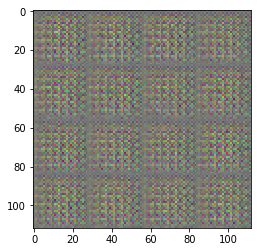

Epoch 1/1... Discriminator Loss: 7.4400... Generator Loss: 0.0018
Epoch 1/1... Discriminator Loss: 3.2336... Generator Loss: 0.1498
Epoch 1/1... Discriminator Loss: 2.6572... Generator Loss: 0.3267
Epoch 1/1... Discriminator Loss: 1.9559... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.8125... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 2.6795... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.8534... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 2.2952... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.7082


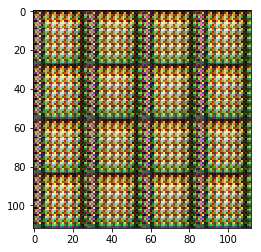

Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.9196... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.6876


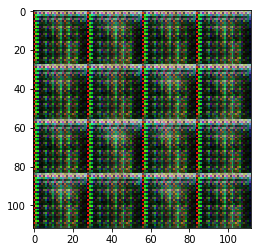

Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 2.3901
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.3662
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.8551
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 2.4286... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9132


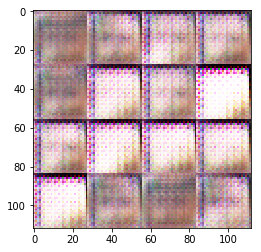

Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 2.4194
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.0067
Epoch 1/1... Discriminator Loss: 2.4487... Generator Loss: 0.4046
Epoch 1/1... Discriminator Loss: 2.0116... Generator Loss: 0.4232


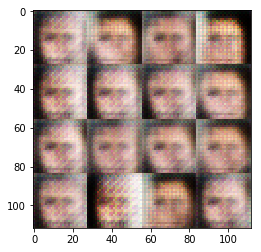

Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.9561... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.7938... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.8620... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.6836... Generator Loss: 0.7075


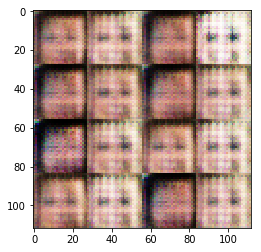

Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 2.0114... Generator Loss: 0.3459
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 2.0181... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.7111... Generator Loss: 1.9679
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.8291... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.6736


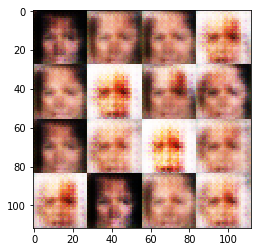

Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.7344


KeyboardInterrupt: 

In [64]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.